CHECKING PRESENT WORKING DIRECTORY

In [1]:
!pwd

/content


CHANGE THE DRIVE LOCATION TO THE DATASET

In [2]:
# Change the drive location to the dataset location
%cd /content/drive/MyDrive/PROJECTS/VIDEO_CAPTIONING/TENSORFLOW_IMPLEMENTATION/data/

/content/drive/MyDrive/PROJECTS/VIDEO_CAPTIONING/TENSORFLOW_IMPLEMENTATION/data


CHECKING PRESENT WORKING DIRECTORY

In [3]:
!pwd

/content/drive/MyDrive/PROJECTS/VIDEO_CAPTIONING/TENSORFLOW_IMPLEMENTATION/data


REMOVING SOME HIDDEN FILES

In [4]:
!rm training_data/video/.*.avi
!rm training_data/feat/.*.npy
!rm testing_data/video/.*.avi
!rm testing_data/feat/.*.npy

rm: cannot remove 'training_data/video/.*.avi': No such file or directory
rm: cannot remove 'training_data/feat/.*.npy': No such file or directory
rm: cannot remove 'testing_data/video/.*.avi': No such file or directory
rm: cannot remove 'testing_data/feat/.*.npy': No such file or directory


IMPORTING LIBRARIES

In [5]:
import numpy as np
import os, sys
import pickle, functools, operator
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime

PREPARING THE DATASET

In [6]:
train_path='/content/drive/MyDrive/PROJECTS/VIDEO_CAPTIONING/TENSORFLOW_IMPLEMENTATION/data/training_data'
TRAIN_LABEL_PATH = os.path.join(train_path, 'training_label.json')

# loading the json file for training
with open(TRAIN_LABEL_PATH) as data_file:    
    y_data = json.load(data_file)

In [7]:
train_videos = [] 
count=0
for y in y_data:
  #print(y['id'])
  train_videos.append(y['id'])
print(train_videos)

['xBePrplM4OA_6_18.avi', 'IBgsLmDcL78_80_84.avi', 'WqQonRVs7WA_0_10.avi', 'F2Ny7rq9RKs_139_148.avi', 'D1tTBncIsm8_841_848.avi', 'Z19zFlPah-o_6_11.avi', 'drsPD5fI1IA_170_180.avi', '6t0BpjwYKco_71_76.avi', 'Hu9Sq1RvuoA_19_62.avi', 'hcCLIzzB1jQ_1_7.avi', 'UXs3eq68ZjE_246_250.avi', 'Ce7equ9zCxk_4_19.avi', 'IWhrWLOAin0_1_4.avi', 'HVR7KpItLfA_62_70.avi', 'r2oI9Y-3wAo_21_28.avi', 'E61HNXjgyqA_22_32.avi', '_o1UXSxTjfo_68_80.avi', 'm1NR0uNNs5Y_192_198.avi', 'kJY5BRCNAs4_3_6.avi', 'QqYWLR47eLI_10_18.avi', 'W8l_ezoU8Lc_76_86.avi', 's80J2dAUUyI_33_43.avi', '-mAoVOhKy0c_4_9.avi', 'IhwPQL9dFYc_24_30.avi', 'nhm_APPwhWk_6_12.avi', 'jcIrD7rNvTM_10_21.avi', 'cJOZp2ZftCw_1_12.avi', '0lh_UWF9ZP4_71_77.avi', 'zv2RIbUsnSw_159_162.avi', 'yd8jh9QYfEs_4_10.avi', 'PqSZ89FqpiY_65_75.avi', 'Kxa0mnDj0bs_15_20.avi', 'cLNrpO6wBk4_37_47.avi', 'nV3Wv8iHp4U_0_38.avi', 'kNHivduxQWg_0_14.avi', 'ACK7SekJWts_140_150.avi', '_QJbjKkfdcs_52_57.avi', '2jXxtQRy47A_30_38.avi', 'QTAqjSbMkXU_65_75.avi', 'PeUHy0A1GF0_28_32.avi', '0

In [8]:
print('Total Videos in the training dataset = ',len(train_videos))

Total Videos in the training dataset =  1450


In [9]:
# mentioning the train test split
train_split = 0.85

In [10]:
# Splitting the videos
# 85% is for training list
# 15% is for validation list
train_list = []
train_list = train_videos[:int(len(train_videos)*train_split)]

print('85% of training videos = ',len(train_list))
#print(train_list)

val_list = []
val_list = train_videos[int(len(train_videos)*train_split):]

print('15% of validaion videos = ',len(val_list))
#print(val_list)

print('\n')
print('Checking whether there is any same video in training & validation set...')

array1 = np.array(train_list)
array2 = np.array(val_list)

print("Common values between two sets:",len(np.intersect1d(array1, array2)))

85% of training videos =  1232
15% of validaion videos =  218


Checking whether there is any same video in training & validation set...
Common values between two sets: 0


In [11]:
# Extracting all the captions from training_label.json
# And concatenate all the captions with their video id
training_list = []

for id in train_list:
  for y in y_data:
      if (y['id']==id):
        for caption in y['caption']:
          caption = "<bos> " + caption + " <eos>"
          if len(caption.split())>10 or len(caption.split())<6:
            continue
          else:
            training_list.append([caption,id])

print('\nSize of Total Training List Captions :',len(training_list))
print('\nTraining List :',training_list)


Size of Total Training List Captions : 14686

Training List : [['<bos> A woman goes under a horse. <eos>', 'xBePrplM4OA_6_18.avi'], ["<bos> A horse defecated on a woman's head. <eos>", 'xBePrplM4OA_6_18.avi'], ["<bos> A horse is defecating on a woman's head. <eos>", 'xBePrplM4OA_6_18.avi'], ['<bos> A horse poops on a woman. <eos>', 'xBePrplM4OA_6_18.avi'], ['<bos> A horse poops on a woman. <eos>', 'xBePrplM4OA_6_18.avi'], ['<bos> A woman goes underneath a horse. <eos>', 'xBePrplM4OA_6_18.avi'], ['<bos> A woman is crawling under a horse. <eos>', 'xBePrplM4OA_6_18.avi'], ['<bos> A woman is walking between horse legs. <eos>', 'xBePrplM4OA_6_18.avi'], ['<bos> A man slicing butter into a bowl. <eos>', 'IBgsLmDcL78_80_84.avi'], ['<bos> A man cut up butter into a pan. <eos>', 'IBgsLmDcL78_80_84.avi'], ['<bos> A man cutting butter into a mixing bowl. <eos>', 'IBgsLmDcL78_80_84.avi'], ['<bos> A man is chopping butter into a container. <eos>', 'IBgsLmDcL78_80_84.avi'], ['<bos> A man is cutting 

In [13]:
# Preparing Validation List same as training list
validation_list = []
for id in val_list:
  for y in y_data:
      if (y['id']==id):
        for caption in y['caption']:
          caption = "<bos> " + caption + " <eos>"
          if len(caption.split())>10 or len(caption.split())<6:
            continue
          else:
            validation_list.append([caption,id])

print('\nSize of Total Validation List Captions :',len(validation_list))
print('\nValidation List :',validation_list)


Size of Total Validation List Captions : 2530

Validation List : [['<bos> Several children practice their routine onstage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> A group of children dance onstage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> A group of kids are dancing. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> Children are dancing on a stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> Children are dancing on stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> Children are singing and dancing. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> Kids are dancing on a stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> Kids are dancing onstage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> Kids dance on a stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> The babies are dancing on stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> The children danced on the stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> The little children danced on the stage. <eos>', 'c75SIlAjfjg_6_14.avi'], ['<bos> A female teacher reads to the class.

In [16]:
#Extracting the captions from the training list & preparing vocab list
vocab_list = []
for train in training_list:
    #print(train[0])
    vocab_list.append(train[0])
print('Size of Vacoabluary list :',len(vocab_list))
print('Vocabulary list : ',vocab_list)

Size of Vacoabluary list : 14686
Vocabulary list :  ['<bos> A woman goes under a horse. <eos>', "<bos> A horse defecated on a woman's head. <eos>", "<bos> A horse is defecating on a woman's head. <eos>", '<bos> A horse poops on a woman. <eos>', '<bos> A horse poops on a woman. <eos>', '<bos> A woman goes underneath a horse. <eos>', '<bos> A woman is crawling under a horse. <eos>', '<bos> A woman is walking between horse legs. <eos>', '<bos> A man slicing butter into a bowl. <eos>', '<bos> A man cut up butter into a pan. <eos>', '<bos> A man cutting butter into a mixing bowl. <eos>', '<bos> A man is chopping butter into a container. <eos>', '<bos> A man is cutting a butter. <eos>', '<bos> A man is slicing butter. <eos>', '<bos> A man puts butter into a mixing bowl. <eos>', '<bos> Butter is being put into a bowl. <eos>', '<bos> Butter is being put into a mixer. <eos>', '<bos> The man cut butter into a bowl. <eos>', '<bos> The man is cutting butter. <eos>', '<bos> A person is adding butte

In [17]:
# Tokenizing the words
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)

print('\nTokenizer output : \n',tokenizer)


Tokenizer output : 


In [18]:
x_data = {}
TRAIN_FEATURE_DIR = os.path.join(train_path, 'feat')

# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir(TRAIN_FEATURE_DIR):
    #print('\nAccessing : ',filename)
    f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename), allow_pickle=True)
    x_data[filename[:-4]] = f

print('Size of Training Feature Data : ',len(x_data))

Size of Training Feature Data :  1450


CREATING CUSTOM DATA GENERATOR

In [19]:
# Creating a custom data generator because we cannot load so many files at once
def load_datatest(train_path, epochs=100, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=1500,training_list=train_list, batch_size=32, maxlen=10):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)
    max_seq_length = train_sequences.shape[1]
    filesize = len(train_sequences)
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    for i in range(epochs):
      for idx in  range(0,filesize):
        n += 1
        encoder_input_data.append(x_data[videoId[idx]])
        y = to_categorical(train_sequences[idx], num_decoder_tokens)
        decoder_input_data.append(y[:-1])
        decoder_target_data.append(y[1:])
        if n == batch_size:
          encoder_input = np.array(encoder_input_data)
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0
          #encoder input : features from the data, decoder input : generated caption & converted into token, decoder target : targeted output we want
          yield ([encoder_input, decoder_input], decoder_target) 

In [20]:
# creating the train and validation generator
train = load_datatest(train_path='training_data',batch_size=320, training_list=training_list, x_data=x_data, epochs=100)
valid = load_datatest(train_path='training_data',batch_size=320, training_list=validation_list, x_data=x_data, epochs=100)

IMPORTANT HYPERPARAMETERS

In [21]:
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=80
num_encoder_tokens=4096
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320
epochs = 100

WRITING MODEL

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 80, 4096)]   0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 10, 1500)]   0                                            
__________________________________________________________________________________________________
endcoder_lstm (LSTM)            [(None, 80, 512), (N 9439232     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, 10, 512), (N 4122624     decoder_inputs[0][0]             
                                                                 endcoder_lstm[0][1]          

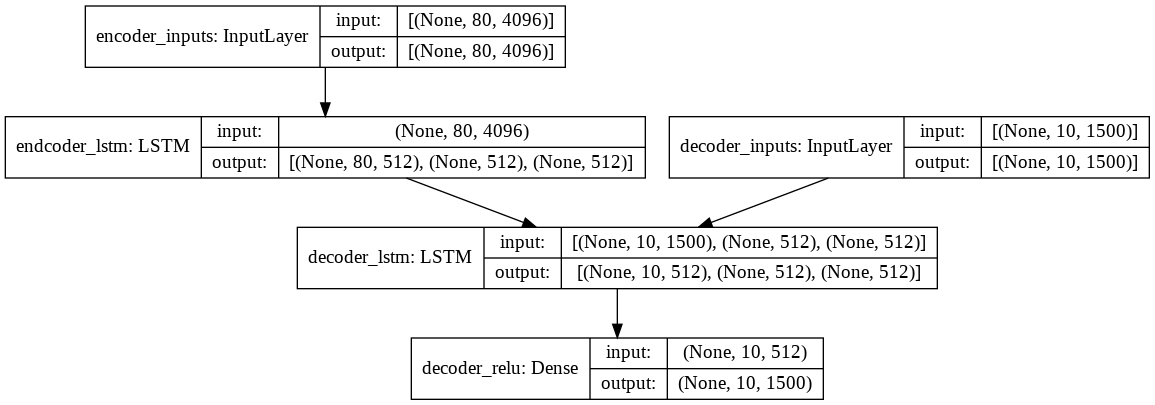

In [22]:
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Setting up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

TRAINING PHASE

In [23]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Run training
opt = keras.optimizers.Adam(learning_rate = 0.0003)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')


try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=epochs, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Epoch 1/100
45/45 [==============================] - 52s 664ms/step - loss: 5.1384 - accuracy: 0.2799 - val_loss: 3.3615 - val_accuracy: 0.3942
Epoch 2/100
45/45 [==============================] - 28s 622ms/step - loss: 3.4618 - accuracy: 0.3887 - val_loss: 3.1567 - val_accuracy: 0.4163
Epoch 3/100
45/45 [==============================] - 27s 589ms/step - loss: 3.2709 - accuracy: 0.4157 - val_loss: 3.0295 - val_accuracy: 0.4477
Epoch 4/100
45/45 [==============================] - 29s 649ms/step - loss: 3.1231 - accuracy: 0.4359 - val_loss: 2.9482 - val_accuracy: 0.4571
Epoch 5/100
45/45 [==============================] - 27s 600ms/step - loss: 2.9855 - accuracy: 0.4535 - val_loss: 2.8934 - val_accuracy: 0.4622
Epoch 6/100
45/45 [==============================] - 27s 593ms/step - loss: 2.8903 - accuracy: 0.4630 - val_loss: 2.8313 - val_accuracy: 0.4685
Epoch 7/100
45/45 [==============================] - 27s 609ms/step - loss: 2.7992 - accuracy: 0.4773 - val_loss: 2.7843 - val_accuracy:

PLOTTING LOSS

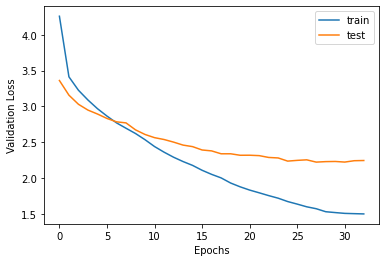

In [24]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='best')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.savefig('loss.png')
plt.show()

PLOTTING ACCURACY

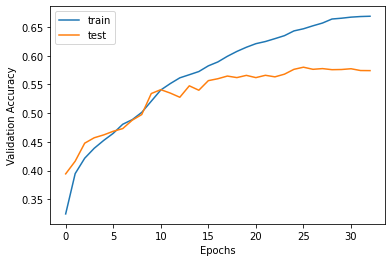

In [25]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='best')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.savefig('accuracy.png')
plt.show()

SAVING MODEL WEIGHT

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 80, 4096)]        0         
_________________________________________________________________
endcoder_lstm (LSTM)         [(None, 80, 512), (None,  9439232   
Total params: 9,439,232
Trainable params: 9,439,232
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, 10, 1500)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            

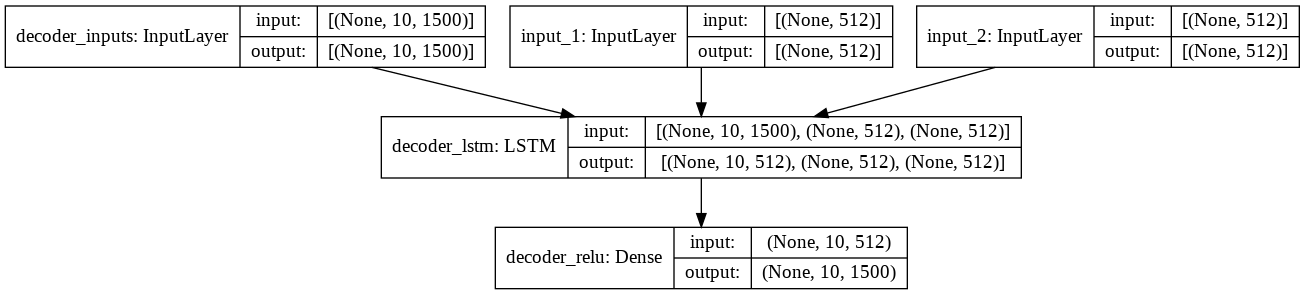

In [26]:
save_model_path = 'model_final'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))
with open(os.path.join(save_model_path,'tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

INFERENCE MODEL STRUCTURE

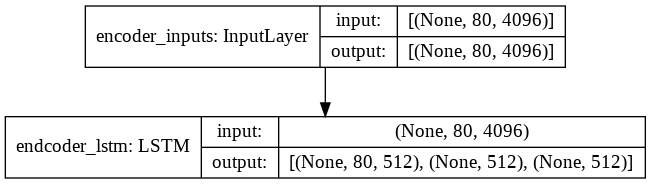

In [27]:
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)